Index(['aid', 'ts', 'type', 'session'], dtype='object')


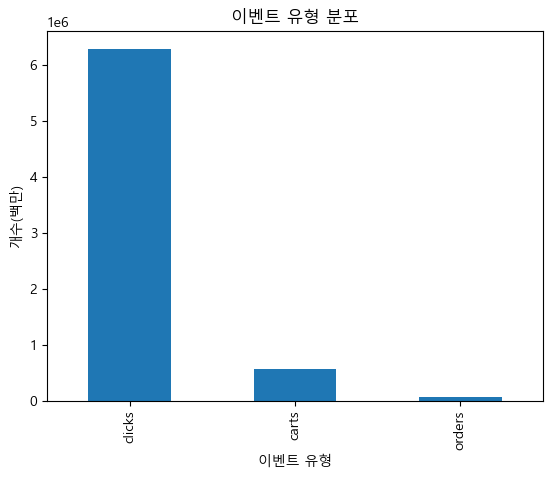

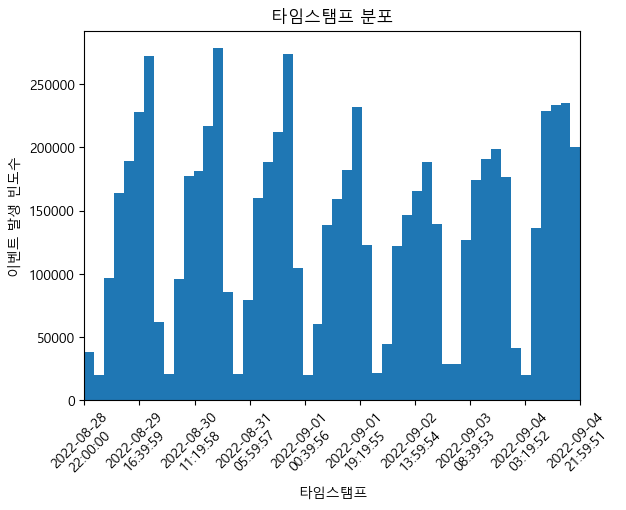

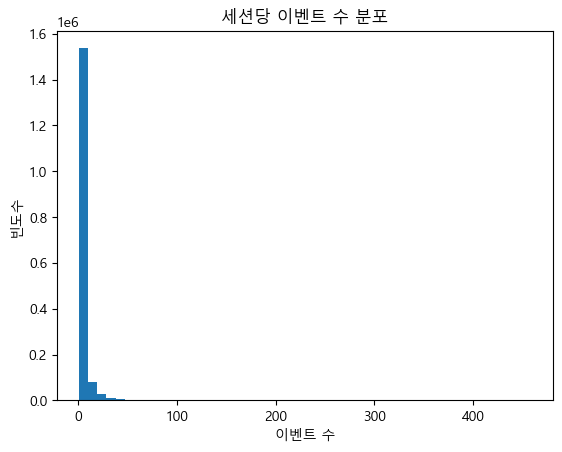

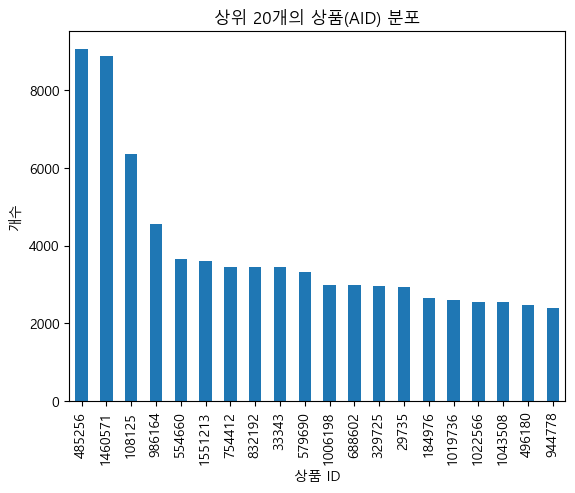

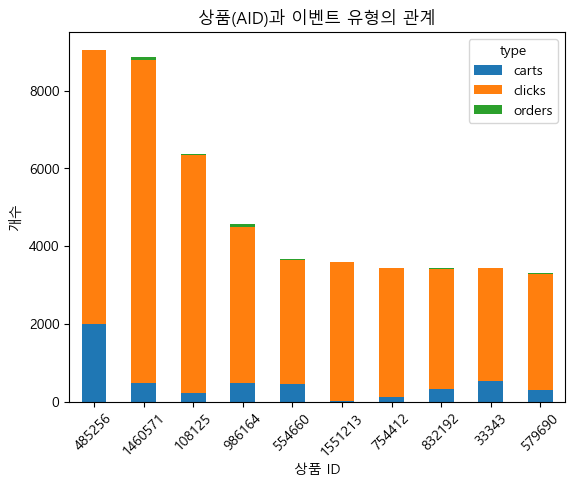

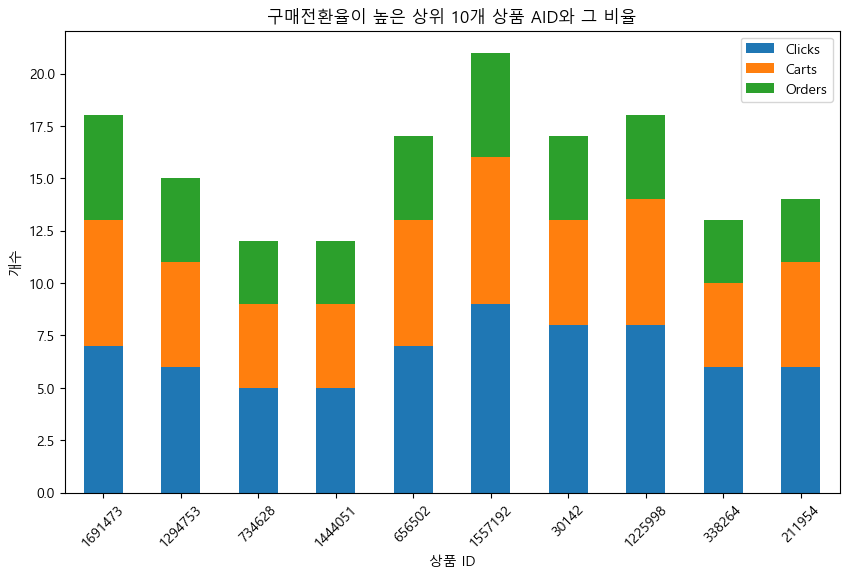

In [18]:
import json
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rc
import datetime
import numpy as np

# JSONL 파일 경로
data_file = "../data/raw/test.jsonl"

# 한글 폰트 설정 (맑은 고딕체)
rc('font', family='Malgun Gothic')

# 한글 깨짐 방지를 위한 유니코드 설정 (한글에서 마이너스(-) 기호가 깨지는 현상 방지)
plt.rcParams['axes.unicode_minus'] = False

### 데이터 로드

data = []
with open(data_file, "r") as file:
    for line in file:
        session_data = json.loads(line.strip())
        data.append(session_data)


### 데이터 전처리

# 세션과 이벤트 데이터를 분리
sessions = []
for session in data:
    session_id = session["session"]
    for event in session["events"]:
        event["session"] = session_id
        sessions.append(event)

# DataFrame 생성
df = pd.DataFrame(sessions)

print(df.columns)


### 시각화


# (1) 이벤트 유형 분포
event_types = df["type"]
event_counts = event_types.value_counts()
event_counts.plot(kind="bar", title="이벤트 유형 분포", ylabel="개수(백만)", xlabel="이벤트 유형")
plt.show()


# (2) 타임스탬프 분포
timestamps = df["ts"]
ax = timestamps.plot(kind="hist", bins=50, title="타임스탬프 분포", ylabel="이벤트 발생 빈도수", xlabel="타임스탬프")

plt.xlim(timestamps.min(), timestamps.max())
xticks = np.linspace(timestamps.min(), timestamps.max(), num=10)
xtick_labels = [datetime.datetime.utcfromtimestamp(ts / 1000).strftime('%Y-%m-%d\n%H:%M:%S') for ts in xticks]
ax.set_xticks(xticks)
ax.set_xticklabels(xtick_labels, rotation=45)

plt.show()


# (3) 세션당 이벤트 수 분포
session_event_counts = df.groupby("session").size()
session_event_counts.plot(kind="hist", bins=50, title="세션당 이벤트 수 분포", ylabel="빈도수(백만)", xlabel="이벤트 수")
plt.show()


# (4) 고유 상품(AID) 분포
aids = df["aid"]
aid_counts = aids.value_counts().head(20)
aid_counts.plot(kind="bar", title="상위 20개의 상품(AID) 분포", ylabel="개수", xlabel="상품 ID")
plt.show()


# (5) AID와 이벤트 유형 관계
aid_event_df = df[["aid", "type"]]
aid_event_counts = aid_event_df.groupby(["aid", "type"]).size().unstack(fill_value=0)

# aid별 총합 계산 및 정렬
aid_event_counts["total"] = aid_event_counts.sum(axis=1)
aid_event_counts = aid_event_counts.sort_values(by="total", ascending=False)

# 상위 10개 선택 후 시각화
aid_event_counts.head(10).drop(columns=["total"]).plot(kind="bar", stacked=True, title="상품(AID)과 이벤트 유형의 관계", ylabel="개수", xlabel="상품 ID")
plt.xticks(ticks=range(len(aid_event_counts.head(10).index)), labels=aid_event_counts.head(10).index, rotation=45)
plt.show()


# (6) 구매 전환율 높은 상품(AID)
# 구매 전환율 계산 및 데이터 정리
aid_event_counts["conversion_rate"] = aid_event_counts["orders"] / (aid_event_counts["clicks"] + 1e-10)
aid_event_counts_sorted = aid_event_counts.sort_values(by="conversion_rate", ascending=False)

# 클릭 > 카트 > 주문 조건 필터링 (단기간 데이터이므로 과거 담아놓은 상품을 주문하는 경우의 집계를 최소화하기 위함)
aid_event_counts_filtered = aid_event_counts_sorted[
    (aid_event_counts_sorted["clicks"] > aid_event_counts_sorted["carts"]) &
    (aid_event_counts_sorted["carts"] > aid_event_counts_sorted["orders"])
]

# 상위 10개 상품 선택
top_10_aid_events = aid_event_counts_filtered.head(10)[["clicks", "carts", "orders"]]

# 시각화 (스택형 막대그래프)
top_10_aid_events.plot(kind="bar", stacked=True, figsize=(10, 6), title="구매전환율이 높은 상위 10개 상품 AID와 그 비율", ylabel="개수", xlabel="상품 ID")
plt.xticks(ticks=range(len(top_10_aid_events.index)), labels=top_10_aid_events.index, rotation=45)
plt.legend(["Clicks", "Carts", "Orders"])
plt.show()